In [1]:
from eventio import SimTelFile
import pandas as pd
import numpy as np
import pickle as pkl
import sys
import time
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [2]:
def test(datafilein = "../simtel_data/proton/data/corsika_run1.simtel.gz"):
    #
    sf = SimTelFile(datafilein)
    tic = time.time()
    toc = time.time()
    #
    it_cout = 0
    file_counter=0
    first_evne_in_file=True
    #
    for ev in sf :
        event_id = -999
        #try :
        #    event_id = ev['event_id']
        #except:
        #    event_id == -999

        #if (it_cout%1000==0) :
        #    toc = time.time()
        #    print('{:10d} {:10d} {:10.2f} s'.format(it_cout, event_id, toc - tic))
        #    tic = time.time()

        if (it_cout%1000==0) :
            toc = time.time()
            print('{:10d} {:10.2f} s'.format(it_cout, toc - tic))
            tic = time.time()
        it_cout = it_cout + 1
    
    sf.close()

In [3]:
def print_ev_info(datafilein = "../simtel_data/proton/data/corsika_run1.simtel.gz",evID=1240202):
    sf = SimTelFile(datafilein)
    for ev in sf:
        #
        if (int(ev['event_id']) == int(evID)):
            print("----------------------------------")
            print("event_id         ", ev['event_id'])
            print("energy           ", ev['mc_shower']['energy'])
            print("xcore            ", ev['mc_event']['xcore'])
            print("ycore            ", ev['mc_event']['ycore'])
            print("ev_time          ", ev['telescope_events'][1]['header']['readout_time'])
            print("nphotons         ", len(ev['photons'][0]))
            print("n_pe             ", ev['photoelectrons'][0]['n_pe'])
            print("n_pixels         ", (ev['photoelectrons'][0]['n_pixels']-np.sum(ev['photoelectrons'][0]['photoelectrons']==0)))
            print("wfshape          ", ev['telescope_events'][1]['adc_samples'][0].shape)
            print("type             ", type(ev['telescope_events'][1]['adc_samples'][0]))
            print("typeadc          ", type(ev['telescope_events'][1]['adc_samples'][0][0][0]))
            print("----------------------------------")
            break
    
    sf.close()

In [4]:
def get_wf(datafilein = "../simtel_data/proton/data/corsika_run1.simtel.gz", evID=1240202):
    sf = SimTelFile(datafilein)
    wf=np.array([], dtype=np.uint16)
    for ev in sf:
        if (int(ev['event_id']) == int(evID)):
            wf=ev['telescope_events'][1]['adc_samples'][0]
            break
    
    sf.close()

    return wf

In [5]:
def get_pixel_mapping(datafilein = "../simtel_data/proton/data/corsika_run1.simtel.gz", outmap_csv = 'pixel_mapping.csv'):
    sf = SimTelFile(datafilein)
    #
    n_pixels=float(sf.telescope_descriptions[1]['camera_organization']['n_pixels'])
    n_drawers=float(sf.telescope_descriptions[1]['camera_organization']['n_drawers'])
    pixel_size=float(sf.telescope_descriptions[1]['camera_settings']['pixel_size'][0])
    #
    the_map=np.concatenate((sf.telescope_descriptions[1]['camera_settings']['pixel_x'].reshape(int(n_pixels),1),
                            sf.telescope_descriptions[1]['camera_settings']['pixel_y'].reshape(int(n_pixels),1),
                            sf.telescope_descriptions[1]['camera_organization']['drawer'].reshape(int(n_pixels),1)), axis=1)
    np.savetxt(outmap_csv, the_map, delimiter=' ',fmt='%f')
    #
    print('n_pixels   = ', int(n_pixels))
    print('n_drawers  = ', int(n_drawers))
    print('pixel_size = ', pixel_size)
    #
    # 0.024300
    # 0.023300
    #
    sf.close()

In [6]:
def rolling_window_sum(arr, window_size, axis):
    cumsum = np.cumsum(arr, axis=axis)
    cumsum_shifted = np.roll(cumsum, shift=1, axis=axis)
    cumsum_shifted[:, 0] = 0  # Set the first element to 0
    return cumsum - cumsum_shifted

In [258]:
def def_clusters_info( n_clusters=0, n_points=0,
                       x_mean=-999.0, y_mean=-999.0, t_mean=-999.0,
                       channelID=-999, timeID=-999):
    clusters_info={'n_clusters':int(n_clusters),
                   'n_points':int(n_points),
                   'x_mean':x_mean,
                   'y_mean':y_mean,
                   't_mean':t_mean,
                   'channelID':int(channelID),
                   'timeID':int(timeID)}
    return clusters_info

In [7]:
df = pd.read_csv('../simtel_data/proton/npe_csv/corsika_run1.npe.csv')

In [8]:
#test()

In [9]:
df[df['n_pe']>10000]

,Unnamed: 0,event_id,energy,azimuth,altitude,h_first_int,xmax,hmax,emax,cmax,xcore,ycore,ev_time,nphotons,n_pe,n_pixels
349,349,1240202.0,2.169607,3.189876,1.238650,11953.206055,483.548401,6221.253418,478.888885,492.044586,-58.272461,41.165516,-56.923855,80660.0,17608.0,2987.0
609,609,2222000.0,51.355724,3.182544,1.278464,20368.396484,373.887146,8099.448242,373.930634,380.122284,-460.855194,85.026459,359.107391,88768.0,18852.0,2043.0
820,820,2970607.0,9.594297,3.222433,1.200817,28665.802734,344.572266,8673.236328,345.015381,357.908966,-33.586414,6.741376,-89.753036,213287.0,22797.0,1111.0
1478,1478,5344906.0,11.021449,3.046977,1.310579,11123.121094,513.189636,5771.373535,511.274506,501.660492,-316.017792,61.312222,175.889023,54250.0,12009.0,3005.0
1782,1782,6456802.0,22.764458,3.084789,1.118771,11118.471680,554.633423,5175.546875,554.144165,553.727478,261.700104,-8.565869,-494.484619,74516.0,12134.0,3658.0
2082,2082,7596703.0,26.231285,3.309019,1.209412,22551.113281,391.287872,7775.134766,388.631592,400.852448,-10.568356,-367.924713,-160.472031,81969.0,27389.0,3882.0
2159,2159,7868805.0,0.110867,3.140634,1.268541,4216.888184,850.000000,1740.061401,850.000000,798.796021,-74.746567,-69.971222,22.936769,43051.0,13783.0,3553.0
2328,2328,8386402.0,6.069890,3.095434,1.236036,15830.558594,382.915131,7929.762695,383.210327,395.764282,-68.325966,-166.258560,-49.206482,133853.0,37075.0,958.0


In [10]:
#print_ev_info(evID=94302)
print_ev_info(evID=1240202)

----------------------------------
event_id          1240202
energy            2.169607162475586
xcore             -58.2724609375
ycore             41.1655158996582
ev_time           -56.92385482788086
nphotons          80660
n_pe              17608
n_pixels          2987
wfshape           (7987, 75)
type              <class 'numpy.ndarray'>
typeadc           <class 'numpy.uint16'>
----------------------------------


In [11]:
wf=get_wf(evID=1240202)
print("wfshape          ", wf.shape)
print("type             ", type(wf))
print("typeadc          ", type(wf[0][0]))

wfshape           (7987, 75)
type              <class 'numpy.ndarray'>
typeadc           <class 'numpy.uint16'>


In [12]:
max_wf=np.amax(wf,axis=1)

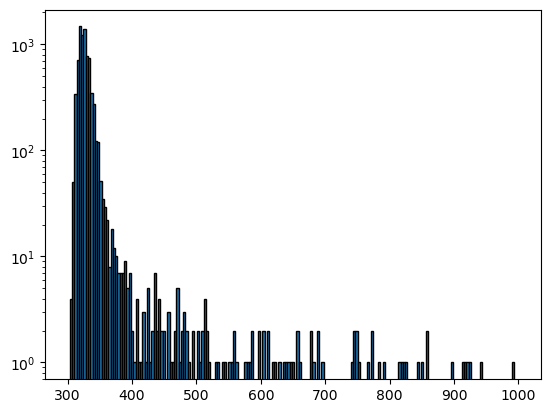

In [13]:
plt.hist(max_wf, bins=np.linspace(300, 1000, num=200), edgecolor='black')
# Add labels and title
#plt.xlabel('npe')
#plt.ylabel('')
#plt.title('npe')
plt.yscale('log')  # Set y-axis to logarithmic scale
#plt.grid(True)
# Show the plot
plt.show()

In [14]:
np.argmax(max_wf)

7313

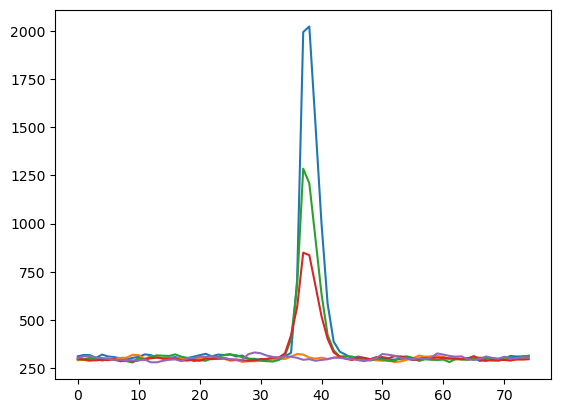

In [15]:
plt.plot(wf[np.argmax(max_wf)])
plt.plot(wf[4426])
plt.plot(wf[7312])
plt.plot(wf[7311])
plt.plot(wf[1])

In [16]:
#get_pixel_mapping()

In [17]:
wf[[0,2,4]]

array([[296, 297, 298, 312, 329, 325, 307, 300, 294, 294, 290, 300, 296,
        298, 305, 297, 298, 295, 304, 307, 295, 306, 307, 305, 300, 290,
        294, 297, 303, 307, 310, 316, 317, 297, 292, 299, 300, 316, 328,
        328, 306, 301, 295, 288, 292, 297, 286, 295, 298, 299, 293, 289,
        300, 296, 304, 298, 293, 299, 302, 298, 315, 322, 323, 307, 305,
        299, 301, 294, 292, 296, 305, 308, 300, 297, 304],
       [315, 304, 304, 302, 296, 301, 291, 293, 290, 291, 297, 301, 295,
        295, 305, 306, 317, 306, 323, 307, 326, 320, 315, 302, 293, 290,
        292, 288, 290, 289, 289, 295, 307, 306, 302, 309, 301, 288, 301,
        306, 295, 303, 292, 305, 299, 296, 291, 293, 300, 293, 299, 294,
        289, 294, 287, 295, 300, 293, 298, 298, 292, 296, 298, 291, 296,
        296, 306, 293, 290, 300, 300, 298, 303, 308, 299],
       [291, 297, 286, 283, 291, 283, 294, 297, 299, 289, 299, 308, 313,
        311, 303, 298, 287, 294, 297, 288, 296, 303, 299, 299, 301, 289,
      

In [18]:
flower_pixID = np.genfromtxt('./pixel_mapping_neighbors.csv',dtype=int)

In [19]:
flower_pixID=flower_pixID+1

In [20]:
print(flower_pixID.shape)

(7987, 6)


In [21]:
flower_seedID=np.arange(1, flower_pixID.shape[0]+1, 1).reshape(flower_pixID.shape[0],1)

In [22]:
flower_pixID=np.concatenate((flower_seedID, flower_pixID), axis=1)

In [23]:
print(flower_pixID)

[[   1    2    3 ...    5    6    7]
 [   2    1    3 ...   13   46   47]
 [   3    1    2 ...   12   13   21]
 ...
 [7985 7955 7961 ... 7981 7984 7986]
 [7986 7954 7955 ... 7981 7985 7987]
 [7987 7969 7970 ... 7982 7986    0]]


In [24]:
flower_pixID[-1]

array([7987, 7969, 7970, 7981, 7982, 7986,    0])

In [25]:
np.sum(flower_pixID[flower_pixID==0])

0

In [26]:
len(flower_pixID[flower_pixID==0])

702

In [27]:
np.sum(wf[[0,2,4]])

67444

In [28]:
np.sum(wf)

180183496

In [29]:
wf.shape

(7987, 75)

In [30]:
wfp=wf.copy()

In [31]:
wfp=np.pad(wfp, pad_width=1)

In [32]:
wfpsl = wfp.copy()

In [33]:
wfpsr = wfp.copy()

In [34]:
wfpsl=np.roll(wfpsl, shift=-1,axis=1)

In [35]:
wfpsr=np.roll(wfpsr, shift=1,axis=1)

In [36]:
wfpsl

array([[  0,   0,   0, ...,   0,   0,   0],
       [296, 297, 298, ..., 304,   0,   0],
       [302, 311, 312, ..., 304,   0,   0],
       ...,
       [293, 297, 289, ..., 303,   0,   0],
       [290, 288, 294, ..., 283,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint16)

In [37]:
wfpsr

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 296, ..., 300, 297, 304],
       [  0,   0, 302, ..., 301, 306, 304],
       ...,
       [  0,   0, 293, ..., 305, 305, 303],
       [  0,   0, 290, ..., 293, 292, 283],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint16)

In [38]:
wfpsl.shape

(7989, 77)

In [39]:
wfp=wfpsl + wfpsr + wfp

In [40]:
wfp

array([[  0,   0,   0, ...,   0,   0,   0],
       [296, 593, 891, ..., 901, 601, 304],
       [302, 613, 925, ..., 911, 610, 304],
       ...,
       [293, 590, 879, ..., 913, 608, 303],
       [290, 578, 872, ..., 868, 575, 283],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint16)

In [41]:
len(wfp[0])

77

In [42]:
wfp[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint16)

In [43]:
digitalsum=np.array([np.sum(wfp[flower_pixID[i]],axis=0) for i in np.arange(0,len(flower_pixID))])

In [44]:
digitalsum

array([[2149, 4286, 6403, ..., 6356, 4242, 2111],
       [2117, 4223, 6308, ..., 6335, 4214, 2092],
       [2138, 4262, 6367, ..., 6405, 4262, 2117],
       ...,
       [2075, 4165, 6239, ..., 6352, 4217, 2107],
       [2067, 4143, 6196, ..., 6298, 4184, 2081],
       [1774, 3541, 5303, ..., 5343, 3551, 1776]], dtype=uint64)

In [45]:
wfp[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint16)

In [46]:
len(wfp)

7989

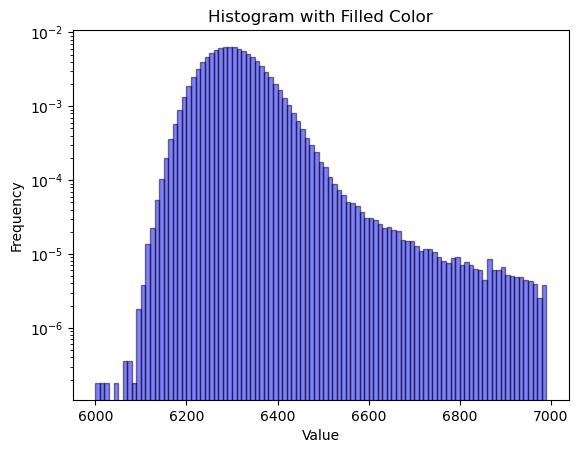

In [47]:
plt.hist(digitalsum.flatten(), bins=np.arange(6000,7000,10), density=True, alpha=0.5, color='blue', edgecolor='black')
# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.ylabel('Frequency')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.title('Histogram with Filled Color')

# Show plot
plt.show()

In [48]:
digitalsum

array([[2149, 4286, 6403, ..., 6356, 4242, 2111],
       [2117, 4223, 6308, ..., 6335, 4214, 2092],
       [2138, 4262, 6367, ..., 6405, 4262, 2117],
       ...,
       [2075, 4165, 6239, ..., 6352, 4217, 2107],
       [2067, 4143, 6196, ..., 6298, 4184, 2081],
       [1774, 3541, 5303, ..., 5343, 3551, 1776]], dtype=uint64)

In [49]:
nbins=np.linspace(6000, 7000, num=100)

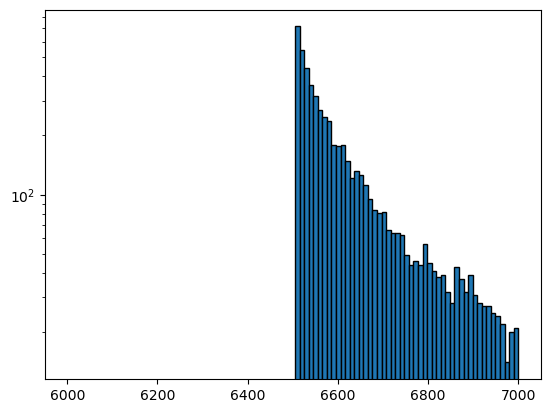

In [50]:
plt.hist(digitalsum[digitalsum>6505].flatten(), bins=nbins, edgecolor='black')
# Add labels and title
#plt.xlabel('npe')
#plt.ylabel('')
#plt.title('npe')
plt.yscale('log')  # Set y-axis to logarithmic scale
#plt.grid(True)
# Show the plot
plt.show()

In [51]:
th=np.array([np.sum(digitalsum>th) for th in nbins])

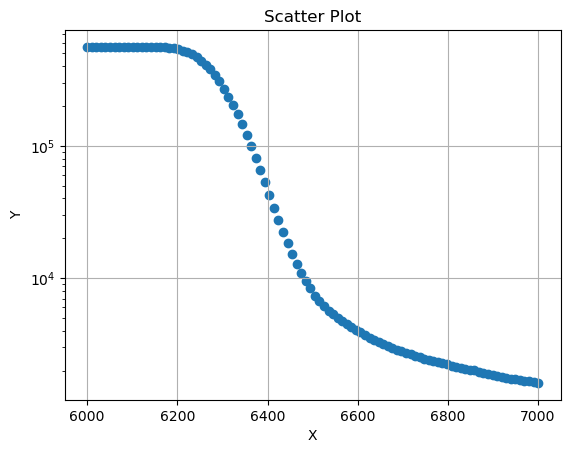

In [52]:

# Create scatter plot
plt.scatter(nbins, th)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)

# Show plot
plt.show()

In [53]:
nbins[th<1000]

array([], dtype=float64)

In [54]:
wf.shape

(7987, 75)

In [55]:
digitalsum.shape

(7987, 77)

In [56]:
len(digitalsum[digitalsum>6505])

7370

In [57]:
digitalsum[:,1:-1].shape

(7987, 75)

In [58]:
digitalsum_rt=digitalsum[:,1:-1]

In [59]:
digitalsum_rt.shape

(7987, 75)

In [60]:
digitalsum_rt

array([[4286, 6403, 6374, ..., 6348, 6356, 4242],
       [4223, 6308, 6314, ..., 6330, 6335, 4214],
       [4262, 6367, 6356, ..., 6403, 6405, 4262],
       ...,
       [4165, 6239, 6233, ..., 6347, 6352, 4217],
       [4143, 6196, 6194, ..., 6314, 6298, 4184],
       [3541, 5303, 5297, ..., 5349, 5343, 3551]], dtype=uint64)

In [61]:
pixelmapping = np.genfromtxt('./pixel_mapping.csv')

In [62]:
pixelmapping.shape

(7987, 3)

(array([ 252.,  733.,  879., 1083., 1001., 1092., 1083.,  879.,  733.,
         252.]),
 array([-1.22058 , -0.976464, -0.732348, -0.488232, -0.244116,  0.      ,
         0.244116,  0.488232,  0.732348,  0.976464,  1.22058 ]),
 <BarContainer object of 10 artists>)

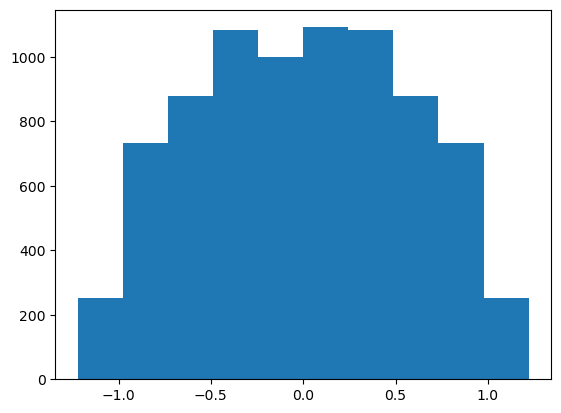

In [63]:
plt.hist(pixelmapping[:,1])

In [64]:
pix_x=pixelmapping[:,0].reshape(pixelmapping.shape[0],1)
pix_y=pixelmapping[:,1].reshape(pixelmapping.shape[0],1)

In [65]:
pix_t=np.array([i for i in np.arange(0,digitalsum_rt.shape[1])]).reshape(1,digitalsum_rt.shape[1])

In [66]:
pix_t.shape

(1, 75)

In [67]:
pix_t=pix_t*0.05

In [68]:
pix_t

array([[0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
        2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25,
        3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 ]])

In [69]:
pix_x=np.concatenate(([pix_x for i in np.arange(0,digitalsum_rt.shape[1])]), axis=1)
pix_y=np.concatenate(([pix_y for i in np.arange(0,digitalsum_rt.shape[1])]), axis=1)

In [70]:
pixelmapping.shape

(7987, 3)

In [71]:
pix_x

array([[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.0243 , 0.0243 , 0.0243 , ..., 0.0243 , 0.0243 , 0.0243 ],
       [0.01215, 0.01215, 0.01215, ..., 0.01215, 0.01215, 0.01215],
       ...,
       [1.0206 , 1.0206 , 1.0206 , ..., 1.0206 , 1.0206 , 1.0206 ],
       [1.03275, 1.03275, 1.03275, ..., 1.03275, 1.03275, 1.03275],
       [1.05705, 1.05705, 1.05705, ..., 1.05705, 1.05705, 1.05705]])

In [72]:
pix_t=np.concatenate(([pix_t for i in np.arange(0,digitalsum_rt.shape[0])]), axis=0)

In [73]:
pix_t

array([[0.  , 0.05, 0.1 , ..., 3.6 , 3.65, 3.7 ],
       [0.  , 0.05, 0.1 , ..., 3.6 , 3.65, 3.7 ],
       [0.  , 0.05, 0.1 , ..., 3.6 , 3.65, 3.7 ],
       ...,
       [0.  , 0.05, 0.1 , ..., 3.6 , 3.65, 3.7 ],
       [0.  , 0.05, 0.1 , ..., 3.6 , 3.65, 3.7 ],
       [0.  , 0.05, 0.1 , ..., 3.6 , 3.65, 3.7 ]])

In [74]:
pix_t.shape

(7987, 75)

In [75]:
pix_y.shape

(7987, 75)

In [76]:
cut_y=pix_y[digitalsum_rt>6505]
cut_x=pix_x[digitalsum_rt>6505]
cut_t=pix_t[digitalsum_rt>6505]

In [77]:
cut_y = np.expand_dims(cut_y,axis=1)

In [78]:
cut_y.shape

(7370, 1)

In [79]:
cut_t.shape

(7370,)

In [80]:
cut_y

array([[ 0.04209],
       [-0.04209],
       [-0.04209],
       ...,
       [ 0.14731],
       [ 0.14731],
       [ 0.14731]])

In [81]:
cut_x = np.expand_dims(cut_x,axis=1)

In [82]:
cut_t = np.expand_dims(cut_t,axis=1)

In [83]:
cut_x

array([[0.     ],
       [0.0243 ],
       [0.0243 ],
       ...,
       [1.03275],
       [1.03275],
       [1.03275]])

In [84]:
X=np.concatenate((cut_x,cut_y,cut_t), axis=1)

In [85]:
X.shape

(7370, 3)

In [211]:
dbscan = DBSCAN(eps=0.1, min_samples=20)
clusters = dbscan.fit_predict(X)

In [212]:
len(clusters[clusters>=0])

6322

In [213]:
cl_ID=np.unique(clusters)

In [214]:
cl_ID=cl_ID[1:]

In [215]:
cl_ID

array([0, 1, 2, 3])

In [216]:
if len(cl_ID) > 0 :
    try:
        clustern = np.max([len(clusters[clusters==clID]) for clID in np.unique(clusters)[1:]])
    except:
        clustern = 0
else:
    clustern = 0

print(len(cl_ID))
print(clustern)

4
6249


In [217]:
len(clusters[clusters==0])

24

In [218]:
len(clusters[clusters==1])

26

In [219]:
len(clusters[clusters==2])

23

In [220]:
len(clusters[clusters==3])

6249

In [221]:
wf.shape

(7987, 75)

In [222]:
np.zeros(wf.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [223]:
clss=np.array([],dtype=int)

In [224]:
clss

array([], dtype=int64)

In [226]:
type(clusters[0])

numpy.int64

In [227]:
type(clusters)

numpy.ndarray

In [228]:
clusters

array([-1,  2,  2, ...,  3,  3,  3])

In [229]:
np.empty(shape=(0,), dtype=int)

array([], dtype=int64)

In [236]:
[len(clusters[clusters==clID]) for clID in np.unique(clusters)[1:]]

[24, 26, 23, 6249]

In [237]:
np.argmax([len(clusters[clusters==clID]) for clID in np.unique(clusters)[1:]])

3

In [234]:
clusters.shape

(7370,)

In [235]:
np.unique(clusters)[1:]

array([0, 1, 2, 3])

In [240]:
np.unique(clusters)

array([-1,  0,  1,  2,  3])

In [241]:
np.unique(clusters)

array([-1,  0,  1,  2,  3])

In [243]:
pointID=np.unique(clusters)

In [245]:
pointID=pointID[pointID>-1]

In [246]:
pointID

array([0, 1, 2, 3])

In [247]:
np.argmax([len(clusters[clusters==clID]) for clID in pointID])

3

In [251]:
len(clusters[clusters==pointID[3]])

6249

In [252]:
ll={'rrr':444}

In [254]:
ll.keys()

dict_keys(['rrr'])

In [256]:
ll

{'rrr': 444}

In [264]:
def_clusters_info()

{'n_clusters': 0,
 'n_points': 0,
 'x_mean': -999.0,
 'y_mean': -999.0,
 't_mean': -999.0,
 'channelID': -999,
 'timeID': -999}

In [295]:
pixelmapping[pixelmapping[:,1]> 0.1].shape

(3584, 3)